Gather the mean values of T2 from every BA in the Historical dataset and create a time series analysis

In [1]:
import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import glob

from pathlib import Path

import scipy.stats

from scipy import stats

In [2]:
def t2_mean(path):
    
    # input the directory to the set of files as a raw string e.g. r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT'
    files_path = path
    list_of_files = glob.glob(os.path.join(files_path , "*.csv"))
    
    # create a list of the mean of T2 of each file
    means_list = []
    for file_name in list_of_files:
        df = pd.read_csv(file_name, index_col = None, header = 0)
        means_list.append(df['T2'].mean())
    
    means_df = pd.DataFrame(means_list, columns = ["T2_Mean"])
    
    # create list of file names to get more information for each T2
    files = []
    for file_path in list_of_files:
        name = os.path.basename(file_path)
        files.append(name)
     
    # split the file names into lists in BA_list
    BA_list_split = []
    for csv_name in range(len(files)):
        base_name = os.path.splitext(os.path.basename(files[csv_name]))[0]
        split = base_name.split("_")
        BA_list_split.append(split)
        
    # take the first elements (BAs) and last elements (years) and put them into their respective lists
    BA_names = []
    years = []
    for file_list in BA_list_split:
        BA_names.append(file_list[0])
        years.append(file_list[5])
        
    # add BA and Year columns to dataframe and correct the column order
    means_df['BA'] = BA_names
    means_df['Year'] = years

    means_df = means_df[['BA', 'Year', 'T2_Mean']]
    
    return means_df

In [3]:
# create a df for both the cold and hot datasets using t2_mean function
hot_df = t2_mean(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT')
cold_df = t2_mean(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD')

In [4]:
def t2_visual(input_BA): # insert a BA as a string e.g. 'AEC'
    
    # need to take the BA string input, and create subsets of hot_df and cold_df from them
    cold_BA = cold_df.loc[(cold_df['BA'] == input_BA)]
    hot_BA = hot_df.loc[(hot_df['BA'] == input_BA)]
    
    # create and show the visualization
    plt.plot(hot_BA['Year'], hot_BA['T2_Mean'], color = "red", label = "Hot")
    plt.plot(cold_BA['Year'], cold_BA['T2_Mean'], color = "blue", label = "Cold")
    
    plt.legend(loc="upper left")
    plt.xlabel('Year')
    plt.title('A Comparison of ' + input_BA + ' Scenarios')
    plt.ylabel('T2_Mean (K)')

    plt.xticks([0, 20, 40, 60, 79])
    
    plt.show()
    
    # express the temperature differences at initial and final points
    temp_diff_df = hot_BA['T2_Mean'] - cold_BA['T2_Mean']
    
    temp_diff_li = list(temp_diff_df)

    # use for loop to print where difference becomes "significant" e.g. 1 dg
    initial_temp_diff = temp_diff_df.iloc[0].round(2)
    final_temp_diff = temp_diff_df.iloc[-1].round(2)
    
    print('2020 temperature difference: ' + str(initial_temp_diff))
    print('2099 temperature difference: ' + str(final_temp_diff))
    
    # add units (kelvin) maybe convert to F
    
    return

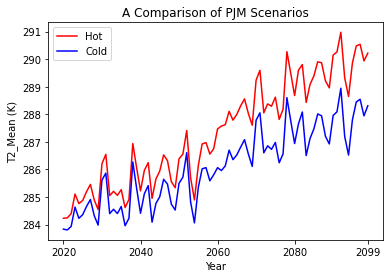

2020 temperature difference: 0.4
2099 temperature difference: 1.91


In [5]:
t2_visual('PJM')

In [6]:
def temp_diff_years(input_temp): # input temp as float/integer.
      
    # get list of unique BAs
    BA_unique = hot_df.BA.unique()
    BA_list = list(BA_unique)
    
    # subset hot/cold data for each BA
    temp_gap_years = []
    for BA_name in BA_list:
        cold_BA = cold_df.loc[(cold_df['BA'] == BA_name)]
        hot_BA = hot_df.loc[(hot_df['BA'] == BA_name)]
        
        # within subset, find temp difference > input temp
        temp_diff_df = hot_BA['T2_Mean'] - cold_BA['T2_Mean']
        temp_diff_li = list(temp_diff_df)
        year_li = list(range(2020, 2099))
    
        for temp_diff in temp_diff_li:
            if temp_diff > input_temp:
                temp_index = temp_diff_li.index(temp_diff)
                break
                
        # take that temp_index, and append to list of temp_gap_years, which is the year the difference between hot and cold first exceeded input_temp
        first_year = year_li[temp_index]
        temp_gap_years.append(first_year)
        
    # sort temp_gap_years in order
    temp_gap_years.sort()

    return temp_gap_years

In [7]:
def temp_divergence_graph(input_deg): # input a float of the degrees K that you would like to see a graph for
    
    # get list of years where the temperature first diverges by the input_deg, using temp_diff_years function
    deg_difference = temp_diff_years(input_deg)
    
    # sort years by ascending order
    deg_difference.sort()
    
    # create dictionary to count number of times each year appears in one_dg
    deg_difference_dict = {i:deg_difference.count(i) for i in deg_difference}
    
    # plot a bar graph
    years = list(deg_difference_dict.keys())
    difference_counts = list(deg_difference_dict.values())
    
    plt.bar(years, difference_counts, color = 'pink')
    plt.xlabel('Year')
    plt.ylabel(str(input_deg) + ' dg K Differences per BA')
    plt.title('Years where Hot and Cold first diverge by ' + str(input_deg) + ' dg K')
    
    return

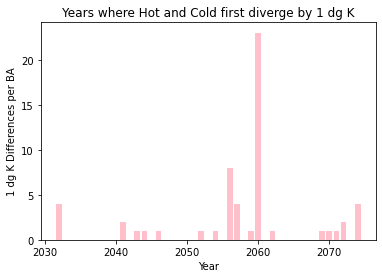

In [8]:
temp_divergence_graph(1)

Connect BAs to their 1dg difference showing up in a dataframe. so then we can see if location is related.

Chunk temp hourly data into 5/10 yr blocks for a given BA in either hot or cold dataset. then get the frequency of those temps (i.e. pdf) for one of those given decades. then repeat for each block. graph these. 

In [169]:
def data_chunk(first_year, files_path, input_BA): # input first_year as an integer: the first year of the decade you want e.g. 2020. input file_path as a raw string directory
                                                  # e.g. r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT' . input input_BA as a string e.g. 'AEC'
    # get a list of the files from the path
    list_of_files = glob.glob(os.path.join(files_path, f'{input_BA}_*.csv'))
    
    # get a list of the elements of each file name
    BA_list_split = []
    for file_index in range(len(list_of_files)):
        base_name = os.path.splitext(os.path.basename(list_of_files[file_index]))[0]
        split = base_name.split("_")
        BA_list_split.append(split)

    # get a list of the BA names, with the same indexes as their original file names
    BA_names = []
    for file_list in BA_list_split:
        BA_names.append(file_list[0])
        
    # get the first file with which to start pulling hourly data
    for file_index in range(len(list_of_files)):
        if input_BA == BA_names[file_index]:
            if str(first_year) in list_of_files[file_index]:
                first_file = list_of_files[file_index]
                break
                
    # get a list of the 10 files to unpack
    index_first_file = list_of_files.index(first_file)
    decade_file_list = []
    for file in list_of_files[index_first_file:]:
        if len(decade_file_list) == 10:
            break
        decade_file_list.append(file)
        
    # create list of all t2 values from each file_name df
    t2_bins = np.arange(250,325,2)
    # t2_values = []
    for file_name in range(len(decade_file_list)):
        
        # read in the file as a df
        df = pd.read_csv(decade_file_list[file_name], index_col = None, header = 0)
        
        # create histogram of t2 values
        hist, bin_edges = np.histogram(df['T2'], bins = t2_bins, density = True) # basically move this out of loop underneath
        
        hist_df = pd.DataFrame(hist, columns = [str(file_name)]) # and this one out too
        
        # aggregate output into a new dataframe:
        if file_name == 0:
            aggregate_output_df = hist_df
        else:
            aggregate_output_df = pd.concat([aggregate_output_df, hist_df], axis = 1) # swap axis to 0
     
    return aggregate_output_df # this is what to apply hist to

           0         1         2         3         4         5         6  \
0   0.000000  0.000000  0.000000  0.000856  0.000514  0.000000  0.000228   
1   0.000000  0.000400  0.000000  0.001199  0.000970  0.000000  0.000398   
2   0.000400  0.001142  0.000000  0.001541  0.001541  0.000000  0.000114   
3   0.000514  0.001199  0.000000  0.000856  0.001998  0.000000  0.000228   
4   0.002797  0.003539  0.000683  0.000913  0.003482  0.000000  0.000683   
5   0.003253  0.004509  0.000398  0.002626  0.006164  0.001313  0.002903   
6   0.003824  0.003767  0.003245  0.002226  0.008276  0.001769  0.002846   
7   0.002226  0.004566  0.004269  0.004452  0.007705  0.003596  0.005066   
8   0.005137  0.008447  0.005066  0.005251  0.009361  0.008162  0.005123   
9   0.014041  0.010388  0.008311  0.010902  0.008619  0.013356  0.007628   
10  0.019749  0.014669  0.014686  0.015411  0.010845  0.016724  0.009677   
11  0.030137  0.021233  0.023793  0.028139  0.020034  0.017123  0.018955   
12  0.025742

Text(0, 0.5, 'Frequency')

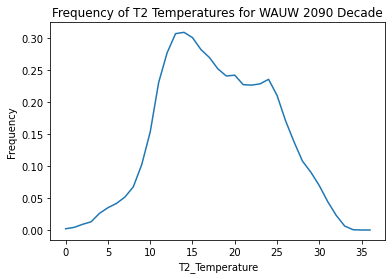

In [183]:
wauw_2090 = data_chunk(2090, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'WAUW')
print(wauw_2090)
# sum row values to be able to plot
wauw_2090_sum = wauw_2090.sum(axis = 1)
print(wauw_2090_sum)
print(wauw_2090_sum.sum())

# plot wauw_2090_sum
plt.plot(wauw_2090_sum)

plt.xlabel('T2_Temperature')
plt.title('Frequency of T2 Temperatures for WAUW 2090 Decade')
plt.ylabel('Frequency')

# plt.xticks(range(250,350))

In [175]:
def BA_decade_plot(input_BA, files_path): # input input_BA as a string e.g. 'AEC' 
                                          # input files_path as raw string e.g. r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT'
    # create list of decades to loop through
    decades = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]
    
    plt.figure(figsize=(25, 10))
    
    # loop through decades, creating a data_chunk of each decade for the input_BA
    for decade in decades:
        data_decade = data_chunk(decade, files_path, input_BA)
        
        # sum the data per bin
        data_decade_sum = data_decade.sum(axis = 1)
        
        # plot the sum on line graph
        plt.plot(data_decade_sum, label = str(decade))
        
    # add information to plot
    plt.legend(loc = "upper right")
    plt.xlabel('T2_Temperature')
    plt.title('Frequency of T2 Temperatures for ' + input_BA)
    plt.ylabel('Frequency')
    
    # need to fix ticks of bins
    # change frequency to percents? make more readable?
    # intuitive colors, red/blue but ensure differentiation
    # add units to xlabel
    
    return

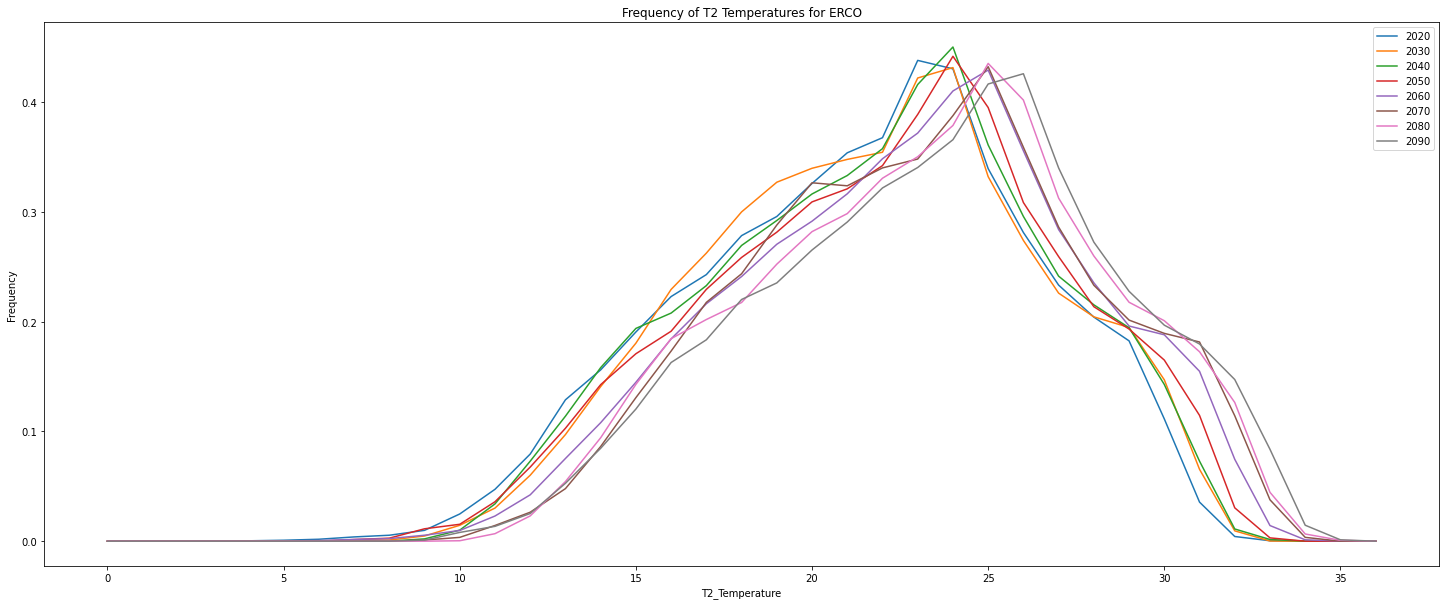

In [179]:
BA_decade_plot('ERCO', r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT')

In [150]:
def BA_hist_plot(input_BA, files_path):
    
    list_of_files = glob.glob(os.path.join(files_path, f'{input_BA}_*.csv'))
    
    # create vector of temperature bins
    t2_bins = np.arange(250,350,5)
    
    # concatenate the output dfs
    years = []
    for i in range(len(list_of_files)):
        
        # stop the loop after 10 years of data
        if i == 10:
            break
            
        # Read in the data for a single year:
        df = pd.read_csv(list_of_files[i], index_col = None, header = 0)
        
        # create a histogram of the temperatures of each df, separated into t2_bins
        hist, bin_edges = np.histogram(df['T2'], bins = t2_bins, density = True)

        # create list of years to use as column names
        base_name = os.path.splitext(os.path.basename(list_of_files[i]))[0]
        split = base_name.split("_")
        years.append(split[5])
    
        hist_df = pd.DataFrame(hist, columns = [str(i)])
    
        if i == 0:
            aggregate_output_df = hist_df
        else:
            aggregate_output_df = pd.concat([aggregate_output_df, hist_df], axis = 1)
            
    aggregate_output_df = aggregate_output_df.rename(columns={'0': years[0], '1': years[1], '2': years[2], '3': years[3], '4': years[4],
                                                              '5': years[5], '6': years[6], '7': years[7], '8': years[8], '9': years[9]})
    
    return aggregate_output_df

In [94]:
aec_2020 = BA_hist_plot('AEC', 'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT')

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000160,0.000137,0.000000,0.000320,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000342,0.000571,0.000000,0.000525,0.000000,0.000000,0.000000,0.000502
3,0.000797,0.001553,0.001142,0.001187,0.000865,0.000959,0.000662,0.000000,0.000319,0.001027
4,0.005647,0.006256,0.003196,0.003539,0.004485,0.008196,0.002443,0.002740,0.005055,0.004132
5,0.014460,0.012717,0.010639,0.014886,0.011339,0.012169,0.011210,0.012808,0.014071,0.013014
6,0.022999,0.024817,0.020913,0.027694,0.022086,0.018881,0.021575,0.025708,0.022268,0.020297
7,0.033724,0.030000,0.029954,0.033265,0.031648,0.021667,0.029932,0.033790,0.030783,0.030525
8,0.034794,0.036233,0.039292,0.035479,0.037546,0.039132,0.037329,0.034566,0.037295,0.037055
9,0.042081,0.043973,0.052694,0.043219,0.051047,0.054680,0.048699,0.044795,0.047131,0.051461


Looping through a decade and concat t2 for all files within a decade (for a given BA), then use that df and apply the hist function to it (rather than what was done earlier, applying hist to each year then concating).